In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

# Building project Smart Cities

## Parameters
### Dimension of the Building 

The bulding is composed of rooms with a cubic shape

https://github.com/QuentinSerpeau/smartcities/blob/main/Model%20Ghiauss.png

The dimensions and surface areas of the building are:
- $l=5 \: \mathrm{m}$ - edge length of the cube;
- $S_d = 2*0.8$ surface of the door
- $S_g = 5^{2}$ surface of the window 
- $S_{ce} = S_g$ surface of the exterior concrete walls;
- $S_{ci} = S_g -S_d $ surface of the interior concrete wall minus the door's surface

In [2]:
l = 5 #lenght and height of the cube
Sd = 2*0.8 #surface of the door
Sg = 5**2 #surface of the window 
Sce = Sg #surface of the exterior concrete walls
Sci = Sg - Sd #surface of the interior concrete wall minus the door's surface

### Thermo-Physical Properties
The wall is made of a width of insulation and a width of concrete (eW=eI+eC)

In [3]:
concrete = {'Conductivity': 1.400,
            'Density': 2400.0,
            'Specific heat': 880,
            'Width': 0.2,
            'Surface': Sce}

insulation = {'Conductivity': 0.027,
              'Density': 55.0,
              'Specific heat': 1210,
              'Width': 0.1,
              'Surface': Sce}

oak = {'Conductivity': 0.16,
              'Density': 780.0,
              'Specific heat': 2400,
              'Width': 0.1,
              'Surface': Sd}

glass = {'Conductivity': 1.4,
         'Density': 2500,
         'Specific heat': 1210,
         'Width': 0.04,
         'Surface': Sg}

wall = pd.DataFrame.from_dict({'Layer_out': insulation,
                               'Layer_in': concrete,
                               'Glass': glass},
                              orient='index')
wall

air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
# pd.DataFrame.from_dict(air, orient='index', columns=['air'])
pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


### Radiative properties

In [4]:
# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
print(f'σ = {σ} W/(m²⋅K⁴)')

σ = 5.67e-08 W/(m²⋅K⁴)


### Convection properties

In [5]:
h = pd.DataFrame([{'in': 8., 'out': 25}])  # W/(m²⋅K)
h

,in,out
0,8.0,25


### Thermal circuit

## Thermal circuit

Heat transfert is:
- through the walls (concrete and insulation), 
- through the glass window,
- by ventilation,
- from the HVAC system.

The HVAC system is modelled as a proportional controller. There is long wave radiative exchange between the wall and the glass window. The sources are:
- temperature sources:
    - outdoor atmospheric air;
    - indoor air temperature setpoint;
- flow rate sources:
    - solar radiation on the outdoor and the indoor walls;
    - auxiliary heat gains in the thermal zone.

Our model is described in the figure below :

https://github.com/dm4bem-2023/Schema%20thermique.png  

concrete & insulation wall: in red;
glass window: in green;
ventilation: in magenta;
indoor volume: in blue (conductances 6 & 7 for convection; conductance 5 for long wave radiation between the walls and the glass window);
HVAC system: in black.

Then, we have our thermal circuit :

https://github.com/Schema%20thermique.png  


The sources are:

 T0  = outdoor temperature °C;
 Ti,sp setpoint temperaure for the indoor air, °C;
 ϕ0 solar radiation absorbed by the outdoor surface of the wall, W;
 ϕi solar radiation absorbed by the indoor surface of the wall, W;
 Qa auxiliary heat gains (i.e., occupants, electrical devices, etc.), W;
 ϕa solar radiation absorbed by the glass, W.


### Thermal coductances
#### Conduction
Conduction conductances, in W/K, are of the form:
$$G_{cd} = \frac{\lambda}{w}S$$
where:

- $\lambda$ - [thermal conductvity](https://en.m.wikipedia.org/wiki/Thermal_conductivity), W/(m⋅K);
- $w$ - width of the material, m;
- $S$ - surface area of the wall, m².

In [6]:
# Conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns={'Conductance'})

,Conductance
Layer_out,6.75
Layer_in,175.00
Glass,875.00


#### Convection
Convection conductances, in W/K, are of the form:
$$G_{cv} = {h S}$$
where:
- $h$ is the [convection coefficient](https://en.m.wikipedia.org/wiki/Heat_transfer_coefficient), W/(m²⋅K);
- $S$ - surface area of the wall, m². 

In [7]:
# Convection wall
Gw = h * wall['Surface'][0]
print(f'Gw = {Gw} W/K')

Gw =       in  out
0  200.0  625 W/K


In [8]:
# Convection glass
Gg = h * wall['Surface'][2]     # glass
print(f'Gg = {Gg} W/K')

Gg =       in  out
0  200.0  625 W/K


In [9]:
# For long wave radiation :

# view factor wall-glass
Fwg = glass['Surface'] / concrete['Surface']
print(f'Fwg = {Fwg}')

Fwg = 1.0


Fo now, we do not need these factors because it complicates the model and we don't take it into account for the moment

#### Advection

The [volumetric flow rate](https://en.m.wikipedia.org/wiki/Volumetric_flow_rate) of the air, in m³/s, is:

$$\dot{V}_a = \frac{\mathrm{ACH}}{3600} V_a$$

where:
- $\mathrm{ACH}$  ([air changes per hour](https://en.m.wikipedia.org/wiki/Air_changes_per_hour)) is the air infiltration rate, 1/h;
- $3600$ - number of seconds in one hour, s/h;
- $V_a$ - volume of the air in the thermal zone, m³.

In [10]:
# Ventilation flow rate
Va = l**3                   # m³, volume of air
ACH = 1                     # air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s, air infiltration
print(f'Va_dot = {Va_dot} m³/s')

Va_dot = 0.034722222222222224 m³/s


In [11]:
# Ventilation & advection
Gv = air['Density'] * air['Specific heat'] * Va_dot
print(f'Gv = {Gv} W/K')

Gv = 41.66666666666667 W/K


#### Proportional controller

In the simplest representation, the [HVAC system](https://en.m.wikipedia.org/wiki/HVAC_control_system) can be considered as a [proportional controller](https://en.m.wikipedia.org/wiki/Proportional_control) that adjusts the heat flow rate $q_{HVAC}$ in order to control the indoor temperature $\theta_i$ at its setpoint value $T_{i,sp}$. The heat flow-rate, in W, injected by the [HVAC](https://en.m.wikipedia.org/wiki/Heating,_ventilation,_and_air_conditioning) system into the controlled space is:

$$ q_{HVAC} = K_p (T_{i, sp} - \theta_i)$$

where:
- $K_p$ is the proportional gain, W/K;
- $T_{i, sp}$ - indoor temperature [setpoint](https://en.m.wikipedia.org/wiki/Setpoint_(control_system)), °C (noted in majuscule because it is an *input, i.e. independent, variable*);
- $\theta_i$ - indoor temperature, °C (noted in minuscule because it is a *output, i.e. dependent variable*).


In [12]:
# Proportionnal controller
# P-controler gain
Kp = 1e3            # almost perfect controller Kp -> ∞


## Thermal Capacities
### Walls

### Thermal capacities
#### Walls
The [thermal capacities](https://en.m.wikipedia.org/wiki/Heat_capacity) of the wall, in J/kg, are:

$$C_w= m_w c_w= \rho_w c_w w_w S_w$$

#### Air
Similarly, the thermal capacity of the air, in J/kg, is:

$$C_a = m_a c_a = \rho_a c_a V_a$$

In [13]:
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
C['Air'] = air['Density'] * air['Specific heat'] * Va
pd.DataFrame(C, columns={'Capacity'})

,Capacity
Layer_out,166375.0
Layer_in,10560000.0
Glass,3025000.0
Air,150000.0


## System of algebraic_differential equations (DAE)
### A : Incident Matrix

> Figure 4. Matrices of the system of Differential-Algebraic Equations (DAE) 
\begin{aligned}
  &C \dot{\theta} = -(A^T G A) \theta + A^T G b + f \\
  &q = G (-A \theta + b)
\end{aligned}

### A: incidence matrix

The [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) is:

$A_{kl} = \begin{cases}\phantom{-}
0 & \text{if branch } q_k \text{ is not connected to node }  \theta_l \\ 
+1 & \text{if branch } q_k \text{ enters into node }  \theta_l\\ 
-1 & \text{if branch } q_k \text{ gets out of node }  \theta_l 
\end{cases}$


In [14]:
A = np.zeros([15, 9])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
A[2, 1] = 1      # branch 2: node 1 
A[3, 1] = 1 # branch 3: node 1 
A[4, 1] = -1 # branch 4: node 1 
A[4, 2] = 1 # branch 4: node 2
A[5, 2] = -1 # branch 4 -> node 2
A[5, 3] = 1 # branch 5 -> node 3
A[14, 1] = -1 # branch 13 -> node 1
A[14, 3] = 1 # branch 13 -> node 3
A[12, 3] = 1 # branch 11 -> node 3
A[13, 3] = 1 # branch 12 -> node 3
A[6, 3] = -1 # branch 6 -> node 3
A[6, 8] = 1 # branch 6 -> node 8
A[7, 8] = -1 # branch 7 -> node 8
A[7, 7] = 1 # branch 7 -> node 7
A[8, 7] = -1 # branch 8 -> node 7
A[8, 6] = 1 # branch 8 -> node 6
A[9, 6] = -1 # branch 9 -> node 6
A[9, 5] = 1 # branch 9 -> node 5
A[10, 5] = -1 # branch 10 -> node 5
A[10, 4] = 1 # branch 10 -> node 4
A[11, 4] = -1 # branch 11 -> node 4


# np.set_printoptions(suppress=False)
# pd.DataFrame(A)

### G : Incident Matrix

### G: conductance matrix

The conductance matrix of the themal circuit.

In [15]:
G = np.zeros([15, 15])       
G[0, 0] = (h['out']*glass['Surface'])              
G[1, 1] = (glass['Conductivity']*glass['Surface'])/glass['Width']
G[2, 2] = Gv
G[3, 3] = Kp
G[4, 4] = (concrete['Conductivity']*concrete['Surface'])/(concrete['Width']/2) + (h['in']*concrete['Surface'])          
G[5, 5] = (concrete['Conductivity']*concrete['Surface'])/(concrete['Width']/2) + (h['in']*concrete['Surface'])
G[6, 6] = (h['in']*insulation['Surface'])
G[7, 7] = (insulation['Conductivity']*insulation['Surface'])/(insulation['Width']/2)
G[8, 8] = (insulation['Conductivity']*insulation['Surface'])/(insulation['Width']/2)                 
G[9, 9] = (concrete['Conductivity']*concrete['Surface'])/(concrete['Width']/2)
G[10, 10] = (concrete['Conductivity']*concrete['Surface'])/(concrete['Width']/2)
G[11, 11] = (h['out']*concrete['Surface'])  
G[12, 12] = Kp 
G[13, 13] = Gv           
G[14, 14] = (h['in']*oak['Surface']) + (oak['Conductivity']*oak['Surface'])/oak['Width']


# print(f'G = ', G)

### C : Capacity Matrix

The capacity matrix of the themal circuit.
The thermal capacities of the air and of the glass can be neglected or not.

In [16]:
neglect_air_glass = True

if neglect_air_glass:
    C = np.diag([0, 0, C['Layer_out'], 0, 0, C['Layer_out'], 0, C['Layer_in'],
                 0])
else:
    C = np.diag([C['Glass'], C['Air'], C['Layer_out'], C['Air'], 0, C['Layer_out'], 0, C['Layer_in'], C['Glass']])

# pd.set_option("display.precision", 3)
# pd.DataFrame(C)

### b : temperature source vector 

The vector of *temperature sources* is $b$, of size $n_q$, the number of branches. An element of the vector $b$ corresponding to a branch without a source is zero. If the flow in a source is from the low potential to the high potential of the source (i.e. from - to +), then the source is positive. If the flow rate in the temperature source is from high potential to low potential (i.e. from + to -), then the source is negative (see [passive sign convention](https://en.m.wikipedia.org/wiki/Passive_sign_convention)). 

In [17]:
b = np.zeros(15)        # nombre de branches
b[[0, 2, 3, 11, 12, 13]] = 1   # branches with temperature sources
print(f'b = ', b)

b =  [1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.]


### f : heat flow source  vector 

The vector of *heat sources* is $f$, of size $n_{\theta}$, the number of nodes. An element of the vector $f$ corresponding to a node without a heat source is zero.

For the thermal circuit shown in Figure 3,

$$f = [\begin{matrix}
\Phi_o &0  &0  &0  &\Phi_i  &0  &\dot{Q_a} &\Phi_a 
\end{matrix}]^T$$

i.e. $f_0 = \Phi_o$, $f_4 = \Phi_i$, $f_6 = \dot{Q_a}$, and $f_7 = \Phi_a$, where:
- $\Phi_o$ - solar radiation absorbed by the outdoor surface of the wall, W;
- $\Phi_i$ - solar radiation absorbed by the indoor surface of the wall, W;
- $\dot{Q}_a$ - auxiliary heat gains (i.e., occupants, electrical devices, etc.), W;
- $\Phi_a$ - solar radiation absorbed by the glass, W.

Since the flow rate sorces $\Phi_o$, $\Phi_i$, $\dot{Q}_a$ and $\Phi_a$ are [time series](https://en.m.wikipedia.org/wiki/Time_series), in vector $f$ the nodes which contain flow rate sources are designated by $1$ and the  nodes without any flow rate source by $0$.

In [18]:
f = np.zeros(9)         # nodes
f[[0, 1, 3, 4]] = 1     # nodes with heat-flow sources
print(f'f = ', f)

f =  [1. 1. 0. 1. 1. 0. 0. 0. 0.]


### y : output vector 

The vector of outputs is $y$, of size $n_{\theta}$, the number of nodes (in this example 8). The non-zero values of $y$ indicate the nodes which are the outputs of the model.

For the thermal circuit shown in Figure 3, if the output is the indoor air temperature, then the output vector is:

$$y = [\begin{matrix}
0  &0  &0  &0  &0  &0  &\theta_6 &0 
\end{matrix}]^T$$

In vector $y$, the nodes for which the temperatures are outputs are noted by $1$ and the other nodes by $0$.

In [19]:
y = np.zeros(9)         # nodes
y[[1, 3]] = 1              # nodes (temperatures) of interest
print(f'y = ', y)

y =  [0. 1. 0. 1. 0. 0. 0. 0. 0.]


## State-space representation


## State-space representation
The [differential-algebraic system of equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations)

$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$

is transformed in [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation) :

$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_s + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$

where:
- $\theta_s$ is the vector of state variables which are the temperatures of nodes containing capacities; the elements are in the same order as in the vector of temperatures, $\theta$; its dimension, $\dim \theta_s$, is equal to the number of capacities from the thermal network; for the circuit presented in Figure 3, $\theta_s = [\theta_1, \theta_3, \theta_6, \theta_7]^T$;

- $u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$ - vector of inputs of dimension $\dim u$ equal to the number of sources (of temperaure, $b_T$, and heat flows, $f_Q$) of the thermal network, where:

    - vector $b_T$ of nonzero elements of vector $b$ of temperature sources; for the circuit presented in Figure 3, $b_T = [T_o, T_o, T_o, T_{i,sp}]^T$ corresponds to branches 0, 8, 10 and 11; 
    - vector $f_Q$ of nonzero elements of vector $f$ of flow sources; for the circuit presented in Figure 3, $f_Q = [\Phi_o, \Phi_i, \dot{Q}_a, \Phi_a]^T$ corresponds to nodes 0, 4, 6, and 7;
    
    
- $y$ - vector of outputs, a subset of vector $\theta$ representing temperature nodes which are of interest; for the circuit presented in Figure 3, $y = \theta_6$, the indoor temperature;

- $A_s$ - state matrix, of dimension $\dim A_s = \dim {\theta_s} \times \dim {\theta_s}$;

- $B_s$ - input matrix, of dimension $\dim B_s = \dim {\theta_s} \times \dim u$;

- $C_s$ - output matrix, of dimension $\dim C_s = \dim y \times \dim {\theta_s}$;

- $D_s$ - feedthrough (or feedforward) matrix, of dimension $\dim D_s = \dim y \times \dim u$.



In [20]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
# print('As = \n', As, '\n')
# print('Bs = \n', Bs, '\n')
# print('Cs = \n', Cs, '\n')
# print('Ds = \n', Ds, '\n')

### Steady State

First we are going to check the model in steady state to see if it is correct.
We are going to consider that : 

- The controller is not active, $K_p \rightarrow 0$,
- The outdoor temperature is $T_o = 10 \, \mathrm{^\circ C}$,
- The indoor temperature setpoint is $T_{i,sp} = 20 \, \mathrm{^\circ C}$,
- All flow rate sources are zero.

In [21]:
b = np.zeros(15)        # temperature sources
b[[0, 13, 2]] = 10      # outdoor temperature
b[[11]] = -10           # outdoor temperature due to the direction of arrows
b[[3, 12]] = 20         # indoor set-point temperature
print(f'b = ', b)

f = np.zeros(9)         # flow-rate sources
print(f'f = ', f)

b =  [ 10.   0.  10.  20.   0.   0.   0.   0.   0.   0.   0. -10.  20.  10.
   0.]
f =  [0. 0. 0. 0. 0. 0. 0. 0. 0.]


### System of Diferential Algebraic Equations (DAE)
The value of temperature in [steady-state](https://en.m.wikipedia.org/wiki/Steady_state) is obtained from the system of DAE by considering that $C \dot{\theta} = 0$:

$$\theta_{ss} = (A^T G A)^{-1}(A^T G b + f)$$

For the conditions mentioned above, in steady-state, all temperatures are equal to $T_o = 10 \, \mathrm{^\circ C}$.

In [22]:
θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

θ = [14.34557734 17.44956116 18.26913922 19.08871729 10.09062525 10.25245604
 10.41428684 14.60990012 18.8055134 ] °C


In [23]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
# print('As = \n', As, '\n')
#print('Bs = \n', Bs, '\n')
# print('Cs = \n', Cs, '\n')
# print('Ds = \n', Ds, '\n')

### State-space representation
The input vector $u$ is obtained by stacking the vectors $b_T$ and $f_Q$:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

where:
- $b_T$ is a vector of the nonzero elements of vector $b$ of temperature sources. For our  circuit, $b_T = [T_o, T_o, T_{i,sp},T_o, T_{i,sp},T_o]^T$ corresponding to branches 0, 2, 3, 11, 12, 13 where:
    - $T_o$ - outdoor temperature, °C;
    - $T_{i,sp}$ - set-point temperaure for the indoor air, °C.
- $f_Q$ - vector the nonzero elements of vector $f$ of flow sources. For the circuit presented in Figure 3, $f_Q = [\Phi_a, \Phi_i, \Phi_o , \Phi_i]^T$ corresponding to nodes 0, 1, 4, and 8 where:
    - $\Phi_o$ - solar radiation absorbed by the outdoor surface of the wall, W;
    - $\Phi_i$ - solar radiation absorbed by the indoor surface of the wall, W;
    - $\Phi_a$ - solar radiation absorbed by the glass, W.

*Note*: Zero in vectors $b$ and $f$ indicates that there is no source on the branch or in the node, respectively. However, a source can have the value zero.

In [24]:
bT = np.array([[10], [10], [20], [10], [20], [10]])     # [To, To, Tisp, To, Tisp, To]
fQ = np.array([[0], [0], [0], [0], [0], [0]])         # [Φa, Φi, Φo, Φi]
u = np.hstack([bT, fQ])
print(f'u = {u}')

u = [[10  0]
 [10  0]
 [20  0]
 [10  0]
 [20  0]
 [10  0]]


The steady-state value of the output of the state-space representation is obtained when $\dot \theta_{C} = 0$:

$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$

In [25]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')                

yss = [[17.43300709  0.        ]
 [18.9919898   0.        ]] °C


The error between the steady-state values obtained from the system of DAE, $\theta_1$ and $\theta_3$, and the output of the state-space representation, $y_{ss}$, 

$$\varepsilon_{1} = \left | \theta_1 - y_{ss} \right |$$
$$\varepsilon_{2} = \left | \theta_3 - y_{ss} \right |$$


is practically zero; the slight difference is due to [numerical errors](https://en.m.wikipedia.org/wiki/Numerical_error).

In [26]:
eps_1=(abs(θ[1] - yss[0,0])) #on calcule l'erreur dans chacune des pièces
print(f'eps1 = \
{eps_1:.2e} °C')
eps_2=(abs(θ[3] - yss[1,0])) #on calcule l'erreur dans chacune des pièces
print(f'eps2 = \
{eps_2:.2e} °C')
print(f'Max error between DAE and state-space =  \
{max(eps_1,eps_2):.2e} °C')

eps1 = 1.66e-02 °C
eps2 = 9.67e-02 °C
Max error between DAE and state-space =  9.67e-02 °C


## Dynamic Simulation

### Time step

The condition for [numerical stability](https://en.m.wikipedia.org/wiki/Euler_method#Numerical_stability) of [Euler explicit integration](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) method is

$$\left |  \lambda_i \Delta t + 1 \right | < 1, \forall \lambda_i, $$

i.e. in the complex plane, $\lambda_i \Delta t$ is inside a circle of radius 1 centered in {-1, 0j}, where:
- $\lambda_i$ are the eigenvalues of matrix $A_s$,
- $\Delta t$ - time step.

For positive real eigenvalues $\left \{ \lambda \in \Re |\lambda >0  \right \}$, which is the case of thermal networks, the above condition [becomes](http://www.math.iit.edu/~fass/478578_Chapter_4.pdf)

$$- \lambda_i \Delta t - 1  < 1, \forall \lambda_i, $$

or

$$ 0 < \Delta t < -\frac{2}{\min \lambda_i} = 2 \min -\frac{1}{\lambda_i} = 2 \min T_i$$

where $T_i$ are the [time constants](https://en.m.wikipedia.org/wiki/Time_constant), $T_i = - \frac{1}{\lambda_i} $

In [27]:
λ = np.linalg.eigvals(As)    # eigenvalues of matrix As

print('Time constants : \n', -1 / λ, 's \n')
print('2 x Time constants : \n', -2 / λ, 's \n')
dtmax = 2 * min(-1. / λ)
print(f'Maximum time step: {dtmax:.6f} s = {dtmax / 60:.6f} min')

Time constants : 
 [2.19819492e+02 4.25661385e+05 7.00913418e+02] s 

2 x Time constants : 
 [4.39638984e+02 8.51322770e+05 1.40182684e+03] s 

Maximum time step: 439.638984 s = 7.327316 min


Let's chose a time step smaller than $\Delta t_{max} = \min (-2 / \lambda_i) $.

In [28]:
# time step

dt = np.floor(dtmax / 60) * 60   # s
print(f'dt = {dt} s = {dt / 60:.0f} min')

dt = 420.0 s = 7 min


pour avoir time step pas trop court approximation de négligence capacité de l'air et de la vitre 

### Settling time
Settling time is roughly 4 times the larger time constant.

In [29]:
# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
print('4 * Time constants: \n', 4 * time_const, 's \n')

t_settle = 4 * max(-1 / λ)
print(f'Settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / (3600):.2f} h = \
{t_settle / (3600 * 24):.2f} days')

4 * Time constants: 
 [    876    2800 1702644] s 

Settling time: 1702646 s = 28377.4 min = 472.96 h = 19.71 days


### Step response
We are now going to determine the dynamic response of the system to a step input.

#### Duration
We pay attention to make the duration of the simulation larger than the estimated settling time. Then it will give a number of time steps in the time vector

In [30]:
# Step response
# -------------
# Find the next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600/100
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
# pd.DataFrame(t, columns=['time'])

Duration = 17028.0 s
Number of time steps = 40


#### Input vector
The input vector as the same shape as in the last part : 
$$
u = \begin{bmatrix}
b_T \\
f_Q
\end{bmatrix}
$$


In [31]:
u = np.zeros([10, n])                # u = [To To Tips To Tisp To Φa, Φi, Φi, Φa]
u[0:2, :] = 10 * np.ones([2, n])    # To = 10 for n time steps (0, 1)
u[2, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps (2)
u[3, :] = 10 * np.ones([1, n])      # To = 10 for n time steps (3)
u[4, :] = 20 * np.ones([1, n])      # To = 20 for n time steps (4)
u[5, :] = 10 * np.ones([1, n])      # To = 10 for n time steps (5)

# pd.DataFrame(u)

#### Time Integration

By integrating the state-space model

$$\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

by using [Euler forward (or explicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) for numerical integration:

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

and [Euler backward (or implicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method) for numerical integration:

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$

where $k = 0, ... , n - 1$,

In [32]:
np.shape(u)
f = np.zeros(9)         # flow-rate sources
f[[0,1,4,8]] = 1

b = np.zeros(15)        # nombre de branches

b[0] = 10    # branches with temperature sources
b[2] = 10
b[3] = 20
b[11] = 10
b[12] = 20
b[13] = 10

print(f'b = ', b)
print(f'f = ', f)


[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
#print('As = \n', As, '\n')
#print('Bs = \n', Bs, '\n')
#print('Cs = \n', Cs, '\n')
#print('Ds = \n', Ds, '\n')

b =  [10.  0. 10. 20.  0.  0.  0.  0.  0.  0.  0. 10. 20. 10.  0.]
f =  [1. 1. 0. 0. 1. 0. 0. 0. 1.]


In [33]:
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])
        
# print(θ_imp)


we then obtain the output : 

$$ y = C_s \theta_s + D_s u$$

for explicit and for implicit Euler methods, respectively. 

In [34]:
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u
# print(y_exp)


The results of explicit and implicit Euler integration are practically identical.

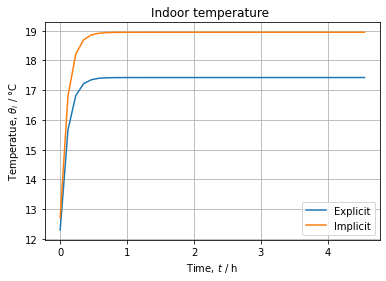

In [35]:
fig, ax = plt.subplots()
ax.plot(t/3600, y_imp.T)
ax.set(xlabel='Time, $t$ / h',
       ylabel='Temperatue, $θ_i$ / °C',
       title='Indoor temperature ')
ax.legend(['Explicit', 'Implicit'])
ax.grid()
plt.show()


> Figure 5. Indoor temperature by using Euler
[implicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method)
and
[explicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) integration.


In [36]:
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model 1: {float(θ[1]):.4f} °C')
print(f'- DAE model 3: {float(θ[3]):.4f} °C')
print(f'- state-space model in room 1 : {float(yss[0][0]):.4f} °C')
print(f'- state-space model in room 2 : {float(yss[1][0]):.4f} °C')
print(f'- steady-state response to step input: {float(y_exp[:, -2][0]):.4f} °C')
print(f'- steady-state response to step input: {float(y_exp[:, -2][1]):.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model 1: 17.4496 °C
- DAE model 3: 19.0887 °C
- state-space model in room 1 : 17.4330 °C
- state-space model in room 2 : 18.9920 °C
- steady-state response to step input: 17.2793 °C
- steady-state response to step input: 18.7701 °C


### Simulation with weather data

#### Start and end time
The simulation will be done from `start_date` to `end_date` indicated in the format `MM-DD HH:MM:SS` (month, day, hour:minute:second).

In [37]:
start_date = '02-05 00:00:00'
end_date = '03-05 18:00:00'

The weather data are for a year. The choice of `2000` for the year is arbitrary; it used in order to respect the format `YYYY-MM-DD HH:MM:SS`.

In [38]:
start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

2000-02-05 00:00:00 	start date
2000-03-05 18:00:00 	end date


#### Inputs
##### Read weather data
Dynamic simulation needs [time series](https://en.m.wikipedia.org/wiki/Time_series) of weather data for air temperature, direct solar radiation on a normal surface and diffuse solar radiation on an horizontal surface (see the tutorial on [Weather data and solar radiation](../t01/t01ReadWeatherData.ipynb)).

In [39]:
filename = './weather_data/CHE_Geneva.067000_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

From the weather data, we select:
- hourly outdoor air temperature, °C;
- hourly solar [direct normal irradiance](https://en.m.wikipedia.org/wiki/Direct_insolation) (or beam radiation), W/m²;
- hourly solar diffuse horizontal irradiance (or [diffuse sky radiation](https://en.wikipedia.org/wiki/Diffuse_sky_radiation)), W/m²,

from the start to the end date.

In [40]:
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]

##### Solar irradiance on the walls
For the surface orientation given by `slope`, `azimuth`and `latitude`, and the `albedo` of the surface in front of the wall, by using the weather data, we can calculate the:
- direct irradiance, W/m²,
- diffuse irradiance, W/m²,
- reflected irradiance, W/m²,

for hourly solar [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance) on a tilted surface.

In [41]:
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, albedo)
# pd.DataFrame(rad_surf)

The total solar [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance)  $E_{tot}$, in W/m², is the sum of direct, diffuse, and reflected components.  

In [42]:
rad_surf['Φtot'] = rad_surf.sum(axis=1)

##### Resample the weather data
The weather data is at the time-step of 1h. It needs to be resampled at time step $\Delta t$ used for numerical integration.

In [43]:
# resample weather data
data = pd.concat([weather['temp_air'], rad_surf['Φtot']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})
# pd.DataFrame(data)

##### Other inputs
Let's consider the indoor temperature setpoint $T_{i,sp} = 20 \, \mathrm{^\circ C}$ and the auxiliary heat flow $\dot{Q}_a = 0 \, \mathrm{W}$ constant for the whole duration of the simulation.

In [44]:
data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])
# pd.DataFrame(data)

##### Input vector in time
The input is formed by the vectors of time series of temperature sources $\left [ T_o, T_o ,T_o, T_{i,sp} \right ]^T$ and vectors of time series of the heat flow sources $\left [ \Phi_o, \Phi_i, \dot{Q_a}, \Phi_a \right ]^T$:

$$u = 
\begin{bmatrix}
T_o\\ 
T_o\\ 
T_{i,sp}\\
T_o\\ 
T_{i,sp}\\ 
T_o\\
\Phi_o\\ 
\Phi_i\\ 
\dot{Q}_a\\ 
\Phi_a
\end{bmatrix}$$

where:

$T_o$ : the time series vector of outdoor temperatures (from weather data), °C.

$T_{i,sp}$ : time series vector of indoor setpoint temperatures, °C.

$\Phi_o$ : time series vector of solar (i.e. short wave) radiation, in W, absorbed by the outdoor surface of the wall:

$$\Phi_o = \alpha_{w,SW} S_w E_{tot}$$

$\Phi_i$ : time series vector of short wave (i.e. solar) radiation, in W, absorbed by the indoor surfaces of the wall:

$$\Phi_i = \tau_{g,SW}  \alpha_{w,SW} S_g E_{tot}$$

$\dot{Q}_a$: time vector of auxiliary heat flows (from occupants, electrical devices, etc.), W.

$\Phi_a$ : time series vector of short wave (i.e. solar) radiation, in W, absorbed by the window glass:

$$\Phi_a = \alpha_{g,SW} S_g E_{tot}$$

In [45]:
# input vector
To = data['To']
Ti = data['Ti']
Φo = α_wSW * wall['Surface']['Layer_out'] * data['Φtot']
Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Φtot']
Qa = data['Qa']
Φa = α_gSW * wall['Surface']['Glass'] * data['Φtot']

u = pd.concat([To, To, Ti, To, Ti, To, Φo, Φi, Qa, Φa], axis=1)
u.columns.values[[6, 7, 9]] = ['Φo', 'Φi', 'Φa']
pd.DataFrame(u)

,To,To,Ti,To,Ti,To,Φo,Φi,Qa,Φa
2000-02-05 00:00:00+01:00,3.100000,3.100000,20.0,3.100000,20.0,3.100000,0.000000,0.00000,0.0,0.000000
2000-02-05 00:07:00+01:00,3.088333,3.088333,20.0,3.088333,20.0,3.088333,0.000000,0.00000,0.0,0.000000
2000-02-05 00:14:00+01:00,3.076667,3.076667,20.0,3.076667,20.0,3.076667,0.000000,0.00000,0.0,0.000000
2000-02-05 00:21:00+01:00,3.065000,3.065000,20.0,3.065000,20.0,3.065000,0.000000,0.00000,0.0,0.000000
2000-02-05 00:28:00+01:00,3.053333,3.053333,20.0,3.053333,20.0,3.053333,0.000000,0.00000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
2000-03-05 17:32:00+01:00,6.360000,6.360000,20.0,6.360000,20.0,6.360000,333.945667,100.18370,0.0,507.597413
2000-03-05 17:39:00+01:00,6.395000,6.395000,20.0,6.395000,20.0,6.395000,253.740500,76.12215,0.0,385.685560
2000-03-05 17:46:00+01:00,6.430000,6.430000,20.0,6.430000,20.0,6.430000,173.535333,52.06060,0.0,263.773707
2000-03-05 17:53:00+01:00,6.465000,6.465000,20.0,6.465000,20.0,6.465000,93.330167,27.99905,0.0,141.861853


#### Initial conditions
The initial value of the state-vector can be zero or different from zero.

In [46]:
θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])

#### Time integration
[Explicit Euler](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) integration in time,

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

where $k = 0, ... , n - 1$,

In [47]:
for k in range(u.shape[0] - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

yields the time variation of state variable $\theta$, from which we obtain the variation of the output (i.e. indoor temperature):

$$y = C_s \theta_s + D_s u$$

and the variation of the heat flow of the HVAC system:

$$q_{HVAC} = K_p (T_{i,sp} - \theta_i) = K_p (T_{i,sp} - y)$$

where $K_p$ is the gain of the P-controller and $T_{i,sp}$ is the HVAC-setpoint for the indoor temperature.

In [48]:
y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])

In [49]:
data['θi_exp_room_0'] = y_exp[0].T
data['θi_exp_room_1'] = y_exp[1].T
data['q_HVAC'] = q_HVAC.T

print(θ_exp)

[[20.         14.51055962 19.5057681  ... 17.85472324 17.78338193
  17.71062625]
 [20.          6.91671964  1.67940652 ... -5.35251033 -5.38583551
  -5.41918077]
 [20.         19.9997647  19.99182057 ... 12.22960725 12.22457754
  12.21918168]]


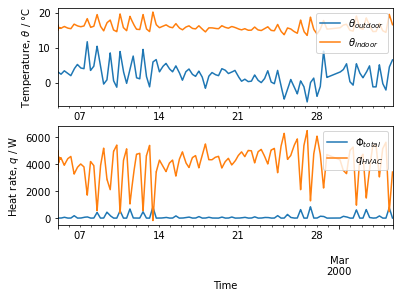

In [50]:
fig, axs = plt.subplots(2, 1)

data[['To', 'θi_exp_room_0']].plot(ax=axs[0],
                            xticks=[],
                            ylabel='Temperature, $θ$ / °C')
axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['Φtot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / W')
axs[1].set(xlabel='Time')
axs[1].legend(['$Φ_{total}$', '$q_{HVAC}$'],
             loc='upper right')
plt.show()

> Figure 6. Simulation in free-running with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

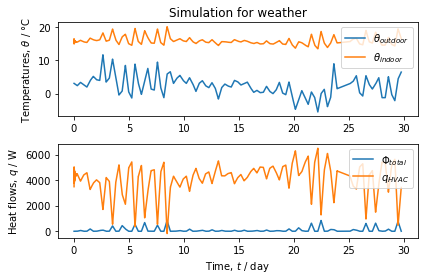

In [51]:
t = dt * np.arange(data.shape[0])   # time vector

fig, axs = plt.subplots(2, 1)
# plot outdoor and indoor temperature
axs[0].plot(t / 3600 / 24, data['To'], label='$θ_{outdoor}$')
axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$θ_{indoor}$')
axs[0].set(ylabel='Temperatures, $θ$ / °C',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, data['Φtot'], label='$Φ_{total}$')
axs[1].plot(t / 3600 / 24, q_HVAC, label='$q_{HVAC}$')
axs[1].set(xlabel='Time, $t$ / day',
           ylabel='Heat flows, $q$ / W')
axs[1].legend(loc='upper right')

fig.tight_layout()

## Discussion

Interchnage the materials  of the layers of the wall. Discuss the step responses and the simuation for weather. Give arguments for the advantages and the disadvanted of indoor and outdoor insulation.

The time step depends on:

- P-controller gain `Kp`:
    - if $K_p \rightarrow \infty$, then the controller is perfect and the time step needs to be small;
    - if $K_p \rightarrow 0$, then, the controller is ineffective and the building is in free-running.
- Capacities considered into the model:
    - if the capacities of the air $C_a =$ `C['Air']` and of the glass $C_g =$ `C['Glass']` are considered, then the time step is small;
    - if the capacities of the air and of the glass are zero, then the time step is large (and the order of the state-space model is reduced).

The controller models an HVAC system able to heat (when $q_{HVAC} > 0$) and to cool (when $q_{HVAC} < 0$).